## This notebook is for doing [dogs and cats challenge](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

print(torch.__version__)
plt.ion()   # interactive mode

1.1.0a0+066d158


In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = '../data'
data_dir = '../data/sample/'

CHECK_POINT_PATH = '../data/checkpoint.tar'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)
print('Train image size: {}'.format(dataset_sizes["train"]))
print('Validation image size: {}'.format(dataset_sizes["val"]))

['cats', 'dogs']
Train image size: 200
Validation image size: 40


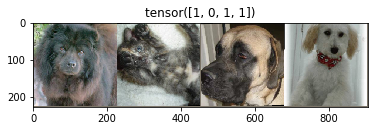

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)

imshow(sample_train_images, title=classes)


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print('Val loss: {}, Val accuracy: {}'.format(checkpoint["best_val_loss"], checkpoint["best_val_accuracy"]))
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print('New best model found!')
                print('New record loss: {}, previous record loss: {}'.format(epoch_loss, best_loss))
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

### Use pretrained model resnet50

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)

In [7]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train model (WITHOUT checkpoint at firts time) and save it

In [10]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

### Validate model with visualization

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

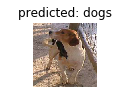

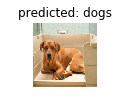

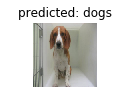

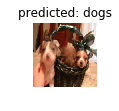

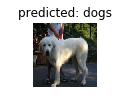

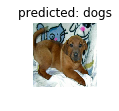

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Train model using checkpoint

In [13]:
for param in model_conv.parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [14]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.09442069455981254, Val accuracy: 0.975
Epoch 0/2
----------
train Loss: 0.4057 Acc: 0.8250
val Loss: 0.2262 Acc: 0.8750

Epoch 1/2
----------
train Loss: 0.4310 Acc: 0.8400
val Loss: 0.4218 Acc: 0.8000

Epoch 2/2
----------
train Loss: 0.3071 Acc: 0.8550
val Loss: 0.0534 Acc: 1.0000
New best model found!
New record loss: 0.05339333713054657, previous record loss: 0.09442069455981254

Training complete in 7m 42s
Best val Acc: 1.0000 Best val loss: 0.0534


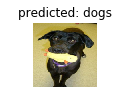

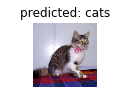

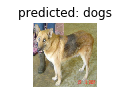

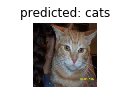

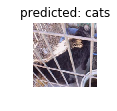

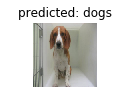

In [15]:
visualize_model(model_conv)

### Create and save submission file - csv file with predictions and its probabilities for images from testset

In [16]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

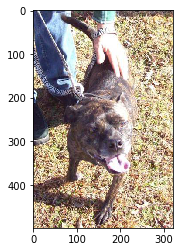

In [17]:
from PIL import Image

test_data_dir = '{}/test'.format(data_dir)
test_data_files = os.listdir(test_data_dir)
im = Image.open('{}/{}'.format(test_data_dir, test_data_files[0]))
plt.imshow(im)

In [18]:
im_as_tensor = apply_test_transforms(im)
print(im_as_tensor.size())
minibatch = torch.stack([im_as_tensor])
print(minibatch.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [19]:
model_conv(minibatch)

tensor([[-2.4513,  2.0408]], grad_fn=<AddmmBackward>)

In [20]:
softMax = nn.Softmax(dim = 1)
preds = softMax(model_conv(minibatch))
preds

tensor([[0.0111, 0.9889]], grad_fn=<SoftmaxBackward>)

In [21]:
def predict_dog_prob_of_single_instance(model, tensor):
    batch = torch.stack([tensor])
    softMax = nn.Softmax(dim = 1)
    preds = softMax(model(batch))
    return preds[0,1].item()

In [22]:
def test_data_from_fname(fname):
    im = Image.open('{}/{}'.format(test_data_dir, fname))
    return apply_test_transforms(im)

In [23]:
import re

def extract_file_id(fname):
    print("Extracting id from " + fname)
    return int(re.search('\d+', fname).group())

extract_file_id("cat34432.jpg")

Extracting id from cat34432.jpg


34432

In [24]:
model_conv.eval()
id_to_dog_prob = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model_conv,
                                                      test_data_from_fname(fname))
                  for fname in test_data_files}

Extracting id from 176.jpg
Extracting id from 913.jpg
Extracting id from 2184.jpg
Extracting id from 11949.jpg
Extracting id from 10954.jpg
Extracting id from 3667.jpg
Extracting id from 721.jpg
Extracting id from 2340.jpg
Extracting id from 7987.jpg
Extracting id from 6452.jpg
Extracting id from 7572.jpg
Extracting id from 1098.jpg
Extracting id from 10574.jpg
Extracting id from 7972.jpg
Extracting id from 12415.jpg
Extracting id from 6409.jpg
Extracting id from 3736.jpg
Extracting id from 12284.jpg
Extracting id from 1487.jpg
Extracting id from 8031.jpg


In [25]:
import pandas as pd

ds = pd.Series({id : label for (id, label) in zip(id_to_dog_prob.keys(), id_to_dog_prob.values())})
ds.head()

176     0.988926
721     0.001114
913     0.973462
1098    0.012271
1487    0.019256
dtype: float64

In [26]:
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.head()

,id,label
176,176,0.988926
721,721,0.001114
913,913,0.973462
1098,1098,0.012271
1487,1487,0.019256


In [27]:
df.to_csv(SUBMISSION_FILE, index = False)